# Sentiment Analysis Modeling on Twitter

For this project I've been asked to develop a natural language processing model to analyze the sentiment of users' tweets. The ultimate goal of this model is to gain an understanding of theses users' feelings about Google and Apple products. 

My approach will be to use count vectorizers to gain a numerical understanding of individual words in the hopes that this will be useful in educating a classifying model. I hope to uncover the most impactful words in conveying the sentiment of the surounding tweet.

To accomplish this we'll be using a small provided dataset of around 9000 tweets, which can be found in the repo.

## Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, precision_score, plot_roc_curve, make_scorer


from yellowbrick.classifier import ROCAUC

import seaborn as sns

from gensim.models import word2vec

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stone\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stone\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Exploration

Importing was a little bit of a challenge. Unlike most csv's, this one wouldn't import simply from running pd.read_csv(). A little Googleing led me to add the encoding='unicode_escape' parameter.

In [3]:
# Importing the sentiment data. Need to encode with unicode escape probably due to unrecognized characters in a number of tweet_text values

df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


Initial observations:

- At least one tweet has unrecognized characters

- _emotion_in_tweet_is_directed_at_ column isn't relevent to a natural language processing approach

- The target column, _is_there_an_emotion_directed_at_a_brand_or_product_, has more than 2 classes

In [6]:
df['tweet_text'].value_counts()

RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                 5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                              4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                 4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                              3
RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter                                       2
                                                                                                                                              ..
Great interview to @mention on Bloomberg TV about #Ipad2 to kick off #SxSW.#apple {link}                                          

In [7]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [8]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In fact there are three target classes. It also appears the classes are very imbalanced.

Now, because of the difficulty I had importing the csv in the first place I'm a little worried about null values so I'll check for them now before moving forward.

In [9]:
df.isnull().values.any()

True

It looks like we've got some. In fact, as indicated by df.info(), most of them are in the column specifying the source of the tweet, though one is in a tweet_text value. I'll replace all the null values with 'Unknown' as I'm not overly concerned about the damage to my data that one tweet being replaced will do. Alternatively I could have just dropped the one row.

In [10]:
df = df.replace(np.nan, 'Unknown')

## Let's do some deeper exploration and see what the most commonly tweeted words are in the set

In [11]:
tokenized_review = []
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
for row in df['tweet_text']:
    for word in tokenizer.tokenize(row):
        tokenized_review.append(word)
#     except TypeError:
#         print(row)

tokenized_review

['wesley83',
 'I',
 'have',
 'a',
 '3G',
 'iPhone',
 'After',
 '3',
 'hrs',
 'tweeting',
 'at',
 'RISE',
 'Austin',
 'it',
 'was',
 'dead',
 'I',
 'need',
 'to',
 'upgrade',
 'Plugin',
 'stations',
 'at',
 'SXSW',
 'jessedee',
 'Know',
 'about',
 'fludapp',
 'Awesome',
 'iPad',
 'iPhone',
 'app',
 'that',
 "you'll",
 'likely',
 'appreciate',
 'for',
 'its',
 'design',
 'Also',
 "they're",
 'giving',
 'free',
 'Ts',
 'at',
 'SXSW',
 'swonderlin',
 'Can',
 'not',
 'wait',
 'for',
 'iPad',
 '2',
 'also',
 'They',
 'should',
 'sale',
 'them',
 'down',
 'at',
 'SXSW',
 'sxsw',
 'I',
 'hope',
 'this',
 "year's",
 'festival',
 "isn't",
 'as',
 'crashy',
 'as',
 'this',
 "year's",
 'iPhone',
 'app',
 'sxsw',
 'sxtxstate',
 'great',
 'stuff',
 'on',
 'Fri',
 'SXSW',
 'Marissa',
 'Mayer',
 'Google',
 'Tim',
 "O'Reilly",
 'tech',
 'books',
 'conferences',
 'amp',
 'Matt',
 'Mullenweg',
 'Wordpress',
 'teachntech00',
 'New',
 'iPad',
 'Apps',
 'For',
 'SpeechTherapy',
 'And',
 'Communication',
 'A

The above list is just a list of every word in every tweet in order.

In [12]:
fdist = FreqDist(tokenized_review)
print(fdist)

<FreqDist with 12540 samples and 164440 outcomes>


In [13]:
fdist

FreqDist({'mention': 7123, 'SXSW': 4822, 'sxsw': 4592, 'link': 4311, 'the': 3939, 'to': 3535, 'RT': 2954, 'at': 2862, 'for': 2443, 'a': 2194, ...})

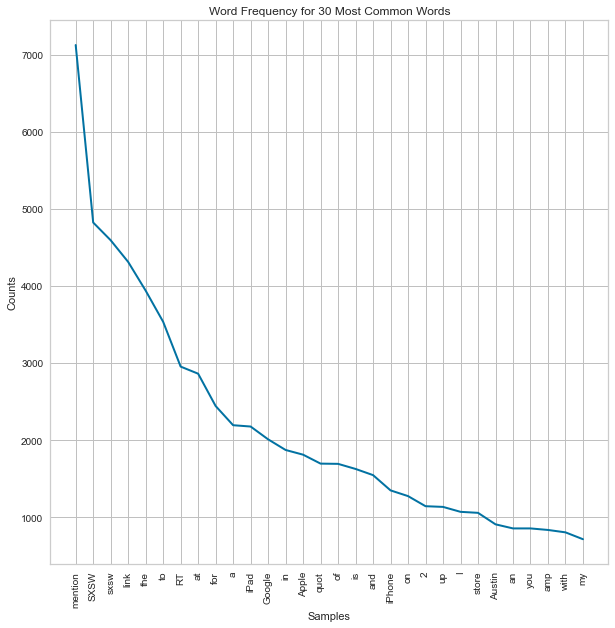

In [14]:
plt.figure(figsize=(10,10))
plt.title('Word Frequency for 30 Most Common Words')
fdist.plot(30)
plt.show()

It seems like almost every one of these tweets is about South by Southwest, also known as SXSW. Behind that in frequency are three words indicating functions in tweets rather than natural language: mention, link, rt (short for retweet) and quot. Let's take another look at this after removing the standard stopwords from the nltk library.

In [15]:
filtered_review = []

for w in tokenized_review:
    if w.lower() not in stopwords.words('english'):
        filtered_review.append(w.lower())

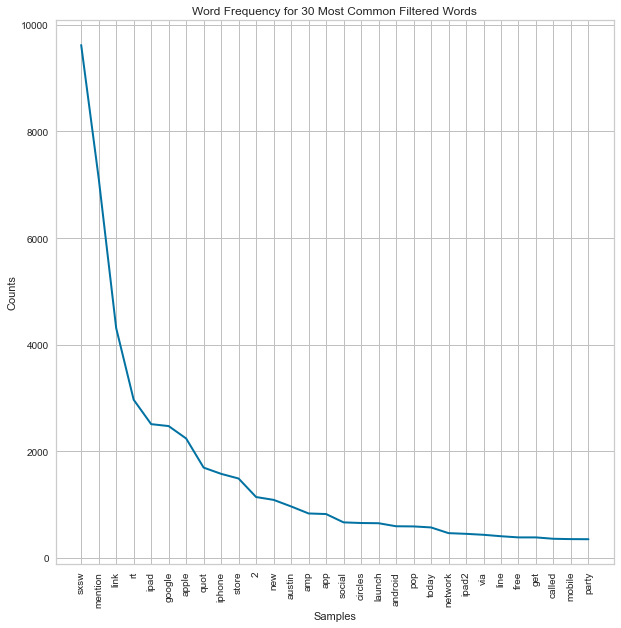

In [16]:
fdist = FreqDist(filtered_review)

plt.figure(figsize=(10,10))
plt.title('Word Frequency for 30 Most Common Filtered Words')
fdist.plot(30)
plt.show()

This looks largely the same though to be sure the last few words on the list are different so some things were cut. Among things that remain are those functional twitter words. Let's add them to a customized stop word list and rerun this.

In [17]:
sw_list = stopwords.words('english')
sw_list += ['mention', 'link', 'rt', 'quot']

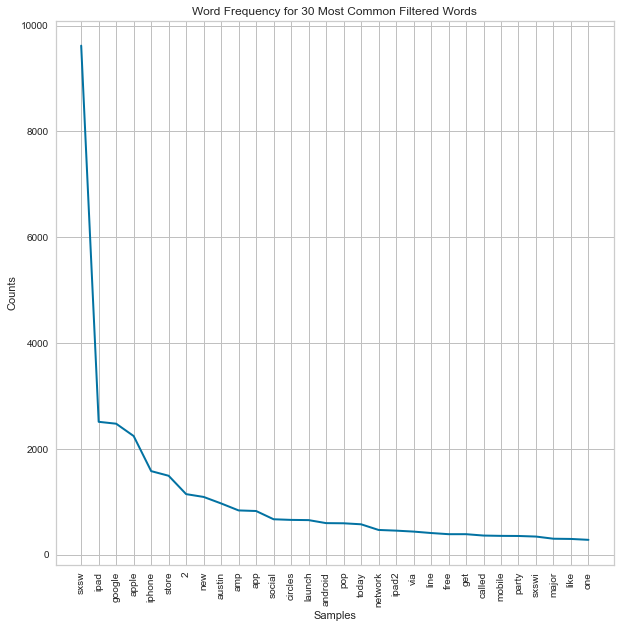

In [18]:
filtered_review = []

for w in tokenized_review:
    if w.lower() not in sw_list:
        filtered_review.append(w.lower())

fdist = FreqDist(filtered_review)

plt.figure(figsize=(10,10))
plt.title('Word Frequency for 30 Most Common Filtered Words')
fdist.plot(30)
plt.show()

Though at this stage it's unlikely to make any notable changes to the graph, it'll be useful for ensuring the accuracy of the models to lemmatize the word list. This essentially makes words with the same root but different endings into the same word so the model can hopefully understand they have basically the same meaning. For example, without this "eat" and "eats" would be considered as completely different words, perhaps losing some meaning in the process.

In [19]:
lemmatizer = WordNetLemmatizer()

lemmatized_review = []
for w in filtered_review:
    lemmatized_review.append(lemmatizer.lemmatize(w))


In [20]:
lemmatized_review

['wesley83',
 '3g',
 'iphone',
 '3',
 'hr',
 'tweeting',
 'rise',
 'austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw',
 'jessedee',
 'know',
 'fludapp',
 'awesome',
 'ipad',
 'iphone',
 'app',
 'likely',
 'appreciate',
 'design',
 'also',
 "they're",
 'giving',
 'free',
 't',
 'sxsw',
 'swonderlin',
 'wait',
 'ipad',
 '2',
 'also',
 'sale',
 'sxsw',
 'sxsw',
 'hope',
 "year's",
 'festival',
 'crashy',
 "year's",
 'iphone',
 'app',
 'sxsw',
 'sxtxstate',
 'great',
 'stuff',
 'fri',
 'sxsw',
 'marissa',
 'mayer',
 'google',
 'tim',
 "o'reilly",
 'tech',
 'book',
 'conference',
 'amp',
 'matt',
 'mullenweg',
 'wordpress',
 'teachntech00',
 'new',
 'ipad',
 'apps',
 'speechtherapy',
 'communication',
 'showcased',
 'sxsw',
 'conference',
 'http',
 'ht',
 'ly',
 '49n4m',
 'iear',
 'edchat',
 'asd',
 'unknown',
 'sxsw',
 'starting',
 'ctia',
 'around',
 'corner',
 'googleio',
 'hop',
 'skip',
 'jump',
 'good',
 'time',
 'android',
 'fan',
 'beautifully',
 'smart',
 'simpl

Again every word but now lemmatized. However, I'm a little skeptical that the built in mapping is going to be comprehensive enough for use with tweets. One of the first words on the list is tweeting, as in tweet but still containing the "-ing" ending. With more time that would be something to look into.

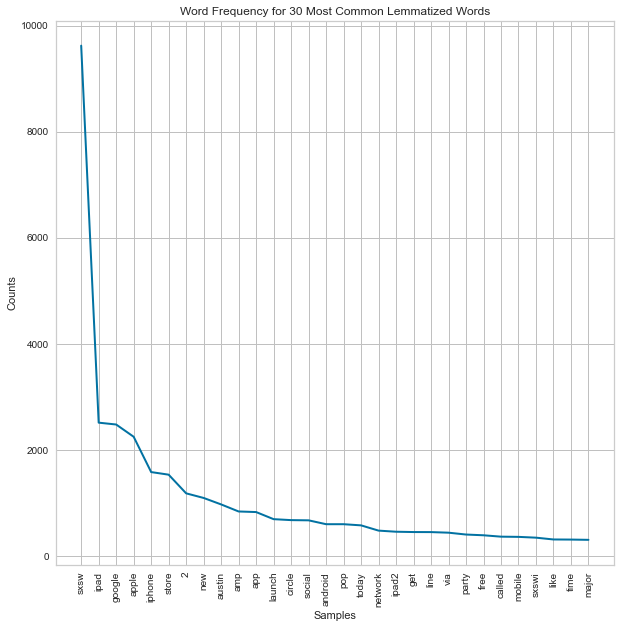

In [21]:
fdist = FreqDist(lemmatized_review)
plt.figure(figsize=(10,10))
plt.title('Word Frequency for 30 Most Common Lemmatized Words')
fdist.plot(30)
plt.show()

## I'm also curious to look at the most common words in positive and negative tweets

In [22]:
df_positive = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']
df_negative = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']

In [23]:
data_positive = df_positive['tweet_text']
data_negative = df_negative['tweet_text']

In [24]:
data_positive

1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
7       #SXSW is just starting, #CTIA is around the co...
8       Beautifully smart and simple idea RT @madebyma...
                              ...                        
9072    @mention your iPhone 4 cases are Rad and Ready...
9077    @mention your PR guy just convinced me to swit...
9079    &quot;papyrus...sort of like the ipad&quot; - ...
9085    I've always used Camera+ for my iPhone b/c it ...
9088                        Ipad everywhere. #SXSW {link}
Name: tweet_text, Length: 2978, dtype: object

In [179]:
data_negative

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
3       @sxsw I hope this year's festival isn't as cra...
17      I just noticed DST is coming this weekend. How...
38      @mention  - False Alarm: Google Circles Not Co...
64      Again? RT @mention Line at the Apple store is ...
                              ...                        
8973    Google guy at #sxsw talk is explaining how he ...
8981    I think my effing hubby is in line for an #iPa...
9008    I'm pretty sure the panelist that thinks &quot...
9043    Hey is anyone doing #sxsw signing up for the g...
9080    Diller says Google TV &quot;might be run over ...
Name: tweet_text, Length: 570, dtype: object

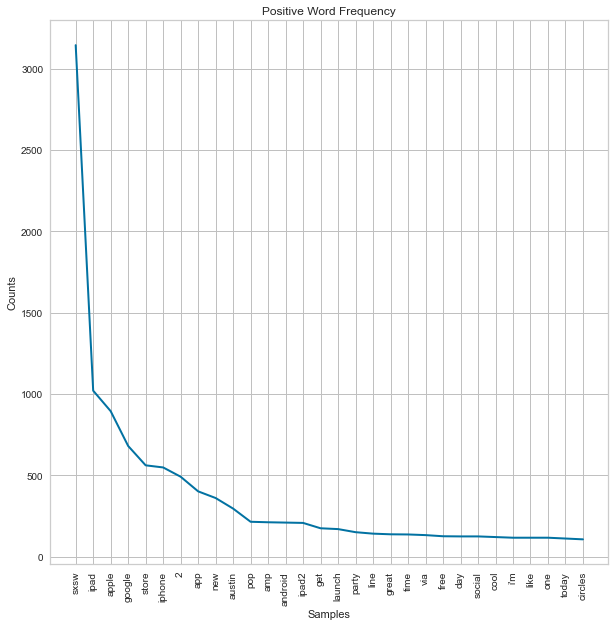

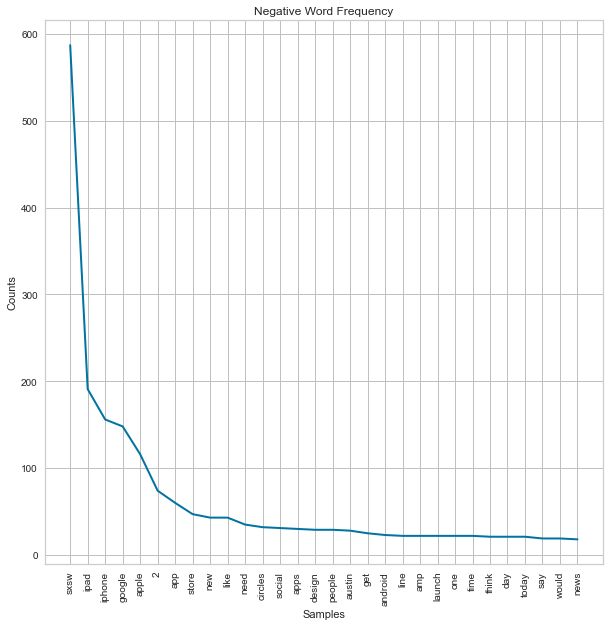

In [25]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')

tokenized_review = []

for row in data_positive:
    for word in tokenizer.tokenize(row):
        if word.lower() not in sw_list:
            word = lemmatizer.lemmatize(word)
            tokenized_review.append(word.lower())

positive_fdist = FreqDist(tokenized_review)
plt.figure(figsize=(10,10))
plt.title('Positive Word Frequency')
positive_fdist.plot(30)
plt.show()


tokenized_review = []

for row in data_negative:
    for word in tokenizer.tokenize(row):
        if word.lower() not in sw_list:
            word = lemmatizer.lemmatize(word)
            tokenized_review.append(word.lower())

negative_fdist = FreqDist(tokenized_review)
plt.figure(figsize=(10,10))
plt.title('Negative Word Frequency')
negative_fdist.plot(30)
plt.show()



In [26]:
positive_fdist.most_common(20)

[('sxsw', 3144),
 ('ipad', 1020),
 ('apple', 894),
 ('google', 680),
 ('store', 561),
 ('iphone', 548),
 ('2', 491),
 ('app', 401),
 ('new', 360),
 ('austin', 295),
 ('pop', 214),
 ('amp', 211),
 ('android', 209),
 ('ipad2', 207),
 ('get', 174),
 ('launch', 169),
 ('party', 150),
 ('line', 141),
 ('great', 137),
 ('time', 136)]

In [27]:
negative_fdist.most_common()

[('sxsw', 587),
 ('ipad', 191),
 ('iphone', 156),
 ('google', 148),
 ('apple', 116),
 ('2', 74),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('need', 35),
 ('circles', 32),
 ('social', 31),
 ('apps', 30),
 ('design', 29),
 ('people', 29),
 ('austin', 28),
 ('get', 25),
 ('android', 23),
 ('line', 22),
 ('amp', 22),
 ('launch', 22),
 ('one', 22),
 ('time', 22),
 ('think', 21),
 ('day', 21),
 ('today', 21),
 ('say', 19),
 ('would', 19),
 ('news', 18),
 ('network', 18),
 ('phone', 18),
 ('fail', 18),
 ('go', 17),
 ('battery', 17),
 ('pop', 17),
 ('long', 17),
 ('product', 17),
 ('look', 17),
 ("i've", 16),
 ("i'm", 16),
 ('1', 16),
 ('good', 15),
 ('see', 15),
 ('much', 15),
 ('america', 15),
 ('back', 14),
 ('thing', 14),
 ('money', 14),
 ('u', 14),
 ('major', 14),
 ('really', 14),
 ('via', 14),
 ('fascist', 14),
 ('company', 14),
 ('way', 14),
 ('talk', 14),
 ('take', 14),
 ('many', 13),
 ('user', 13),
 ('going', 13),
 ('mobile', 13),
 ('ipad2', 13),
 ('already', 13),
 (

While there are differences in the lists they're not terribly stark. My initial takeaway is that the most common words in positive and negative tweets are largely the same. The difference is going to come down to very specific determinitive words. This is futher demonstrated by the following frequency plots and word clouds.

<AxesSubplot:xlabel='Word'>

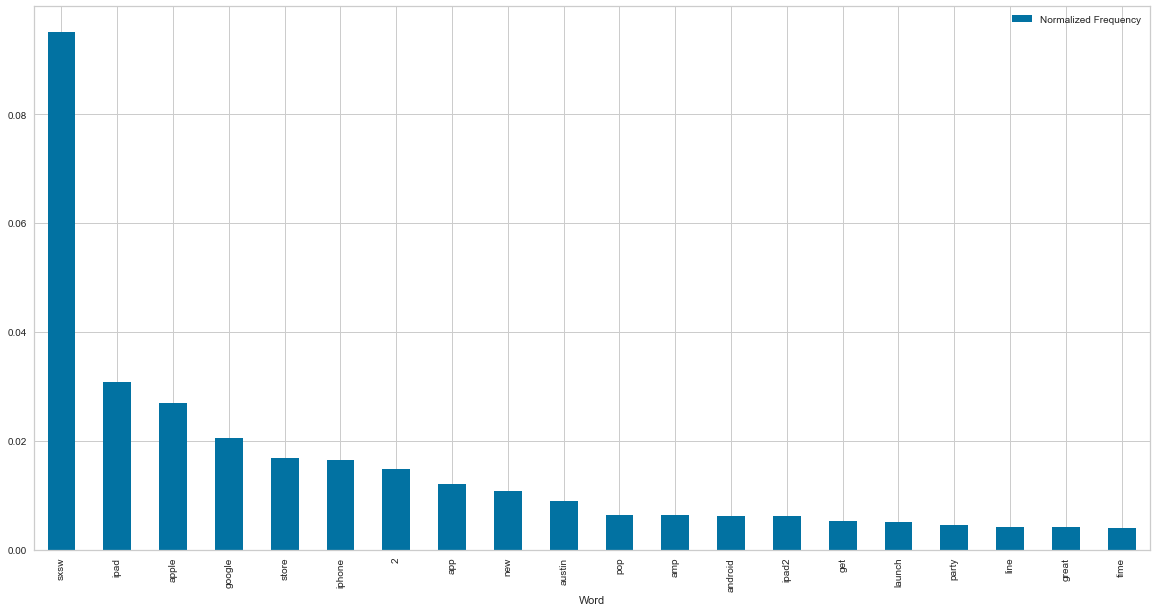

In [31]:
positive_total_word_count = sum(positive_fdist.values())
positive_tops = positive_fdist.most_common(20)
positive_frequency_df = pd.DataFrame(positive_tops, columns=['Word', 'Frequency'])
positive_frequency_df = positive_frequency_df.set_index('Word')
positive_frequency_df['Normalized Frequency'] = positive_frequency_df['Frequency']/positive_total_word_count
positive_frequency_df.nlargest(20, columns=['Frequency']).plot(kind='bar', y = 'Normalized Frequency', figsize=(20,10))

<AxesSubplot:xlabel='Word'>

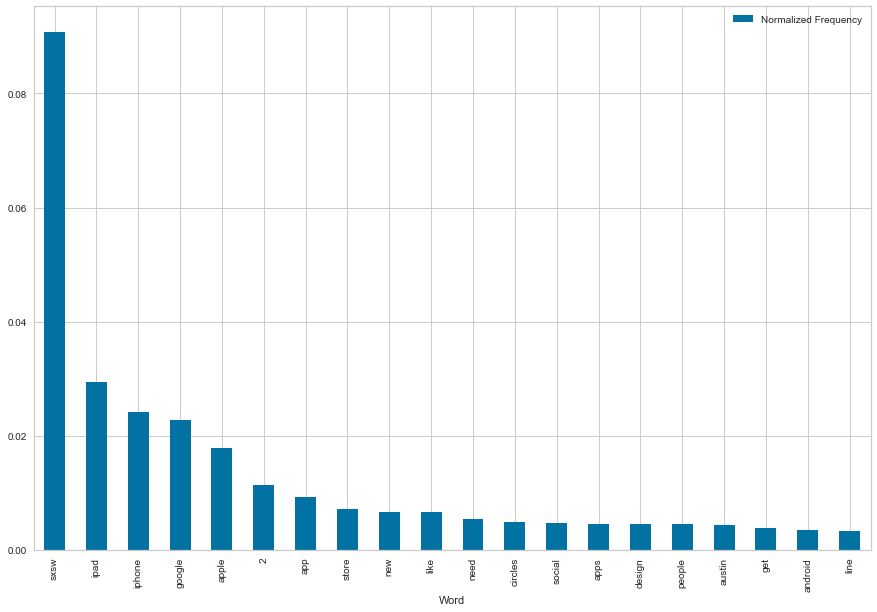

In [32]:
negative_total_word_count = sum(negative_fdist.values())
negative_tops = negative_fdist.most_common(20)
negative_frequency_df = pd.DataFrame(negative_tops, columns=['Word', 'Frequency'])
negative_frequency_df = negative_frequency_df.set_index('Word')
negative_frequency_df['Normalized Frequency'] = negative_frequency_df['Frequency']/negative_total_word_count

negative_frequency_df.nlargest(20, columns=['Frequency']).plot(kind='bar', y = 'Normalized Frequency', figsize=(15,10))

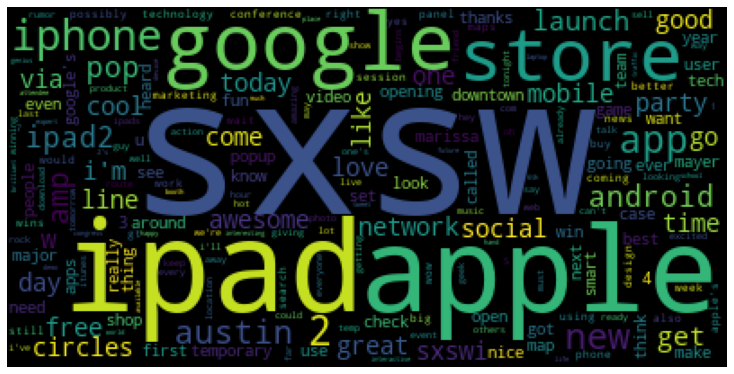

In [33]:
wordcloud = WordCloud().generate_from_frequencies(positive_fdist)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

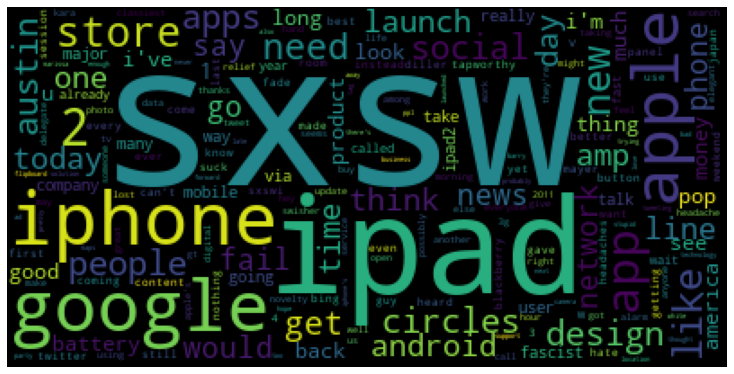

In [35]:
wordcloud = WordCloud().generate_from_frequencies(negative_fdist)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

## Classification

The goal of this project is to derive a predicted sentiment - positive, negative, or neutral - from a tweet based on the words in the tweet. The simplest way to accomplish this I feel would be to simply gather a list of words with positive and negative connotations and score each tweet based on the presence of these words. I'll give a +1 for every positive word and a -1 for every negative.

In [46]:
# lists of negative and positive words from enchantedlearning.com
from bs4 import BeautifulSoup
import requests

negative_words_url = "https://www.enchantedlearning.com/wordlist/negativewords.shtml"
positive_words_url = "https://www.enchantedlearning.com/wordlist/positivewords.shtml"

html = requests.get(negative_words_url).content

soup = BeautifulSoup(html)

negative_divs = soup.find_all("div", {"class": "wordlist-item"})

negative_words = [x.get_text() for x in negative_divs]

html = requests.get(positive_words_url).content

soup = BeautifulSoup(html)

positive_divs = soup.find_all("div", {"class": "wordlist-item"})

positive_words = [x.get_text() for x in positive_divs]

In [47]:
# splitting rows into word lists which will be scored based on the negative_words and positive_words lists

tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
lemmatizer = WordNetLemmatizer()

r = []
data = []


# I'm not excluding stop words because in this model they shouldn't have any unintended semantic meaning, i.e. if they're on a positive/negative list it's for a reason

for row in df['tweet_text']:
    for word in tokenizer.tokenize(row):
        r.append(lemmatizer.lemmatize(word.lower()))
    data.append(r)
    r = []

data = pd.Series(data, name='tweet_text')
target = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [48]:
# pd.DataFrame wants to put the index in the columns, needs to be transposed
simple_model_df = pd.DataFrame([data, target]).transpose()

simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,"[wesley83, i, have, a, 3g, iphone, after, 3, h...",Negative emotion
1,"[jessedee, know, about, fludapp, awesome, ipad...",Positive emotion
2,"[swonderlin, can, not, wait, for, ipad, 2, als...",Positive emotion
3,"[sxsw, i, hope, this, year's, festival, isn't,...",Negative emotion
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",Positive emotion
...,...,...
9088,"[ipad, everywhere, sxsw, link]",Positive emotion
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",No emotion toward brand or product
9090,"[google's, zeiger, a, physician, never, report...",No emotion toward brand or product
9091,"[some, verizon, iphone, customer, complained, ...",No emotion toward brand or product


As far as I can tell, the "No emotion..." and "I can't tell" are functionally similar so in my models I'll be counting them both as a pseudo-neutral option between positive and negative.

In [54]:
def word_search_model(tweet, neutral_option=True):
    '''A simple model which takes in a single tweet and analyzes it based on lists of known positive and negative sentiment words. The function returns a score of 1 for tweets percieved as having a positive sentiment, 0 for neutral, and -1 for negative.

    Keyword arguements:
    tweet - a list/tuple/string containing an English language sentence or phrase
    neutral_option - whether or not the function should return neutral sentiments. If false, neutral estimates will be rounded up to positive

    '''
    sentiment_score = 0

#     to account for tweets coming in in any uninteded format
    if type(tweet) == list:
        pass
    elif type(tweet) == tuple:
        tweet = tweet[0]
    elif type(tweet) == str:
        r = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(tweet)]
        tweet = r

    for word in tweet:
        if word in positive_words:
            sentiment_score += 1
        elif word in negative_words:
            sentiment_score -= 1
    
#     if sentiment_score is 1 or above, set to 1. if sentiment_score is below 0, set to -1
    if (
        neutral_option
        and sentiment_score > 0
        or not neutral_option
        and sentiment_score >= 0
    ):
        sentiment_score = 1
    if sentiment_score < 0:
        sentiment_score = -1

    return sentiment_score
    

We'll run the dataset through this function above and attach the predictions to the simple_model_df.

In [55]:
simple_model_df['prediction'] = simple_model_df['tweet_text'].apply(word_search_model)

In [56]:
simple_model_df['prediction'].value_counts()

 0    5031
 1    3246
-1     816
Name: prediction, dtype: int64

In [57]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, i, have, a, 3g, iphone, after, 3, h...",Negative emotion,-1
1,"[jessedee, know, about, fludapp, awesome, ipad...",Positive emotion,1
2,"[swonderlin, can, not, wait, for, ipad, 2, als...",Positive emotion,-1
3,"[sxsw, i, hope, this, year's, festival, isn't,...",Negative emotion,0
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",Positive emotion,1
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",Positive emotion,0
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",No emotion toward brand or product,0
9090,"[google's, zeiger, a, physician, never, report...",No emotion toward brand or product,-1
9091,"[some, verizon, iphone, customer, complained, ...",No emotion toward brand or product,0


In order to compare the target column with my predictions I'll need to map the strings to their numeric equivilent.

In [58]:
simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] = simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else(-1 if x == 'Negative emotion' else 0))

In [59]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, i, have, a, 3g, iphone, after, 3, h...",-1,-1
1,"[jessedee, know, about, fludapp, awesome, ipad...",1,1
2,"[swonderlin, can, not, wait, for, ipad, 2, als...",1,-1
3,"[sxsw, i, hope, this, year's, festival, isn't,...",-1,0
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",1,1
...,...,...,...
9088,"[ipad, everywhere, sxsw, link]",1,0
9089,"[wave, buzz, rt, mention, we, interrupt, your,...",0,0
9090,"[google's, zeiger, a, physician, never, report...",0,-1
9091,"[some, verizon, iphone, customer, complained, ...",0,0


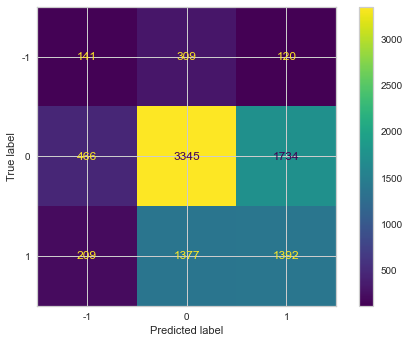

In [60]:
ConfusionMatrixDisplay.from_predictions(simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'], simple_model_df['prediction'])

# confusion_matrix(word_search_model, simple_model_df['tweet_text'], simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'])

In [61]:
print('Overall Accuracy Score')
accuracy_score(simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'], simple_model_df['prediction'])

0.5364566149785549

In [65]:
print('True Positives/Predicted Positives')
print(accuracy_score(simple_model_df[simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] == 1]['is_there_an_emotion_directed_at_a_brand_or_product'], simple_model_df[simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] == 1]['prediction']))

print('True Neutrals/Predicted Neutrals')
print(accuracy_score(simple_model_df[simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] == 0]['is_there_an_emotion_directed_at_a_brand_or_product'], simple_model_df[simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] == 0]['prediction']))

print('True Negatives/Predicted Neutrals')
print(accuracy_score(simple_model_df[simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] == -1]['is_there_an_emotion_directed_at_a_brand_or_product'], simple_model_df[simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] == -1]['prediction']))

True Positives/False Neutrals and Negatives
0.4674278038952317
True Neutrals/False Positives and Negatives
0.6032461677186655
True Negatives/False Neutrals and Positives
0.24736842105263157


My simple model did an alright job classifying the tweets overall. A random guess would likely be around 33% accurate given the three classes. With that in mind, my model was better at classifying neutrals, followed by positives. It was actually worse than random at classifying negatives however.

Now, onto some more complicated models.

To start off here, I've brought in a ModelRunner class based on a series of functions from an older project. The purpose of this is to be able to tinker with models without having to copy repetitive code or account for ways in which different models might need to be evaluated differently. It takes in information about the models being run as well as a pipeline object and returns a series of metrics and graphs which can be used to understand how the model performs and which words it finds most informative.

In [67]:
class ModelRunner:
    """
    For evaluating a pipeline or series of pipelines for their effectiveness at predicting the target in this sentiment analysis.
    
    ...
    Attributes
    ----------
    model : tuple or list
        the first index is expected to be a dictionary with the names of the classifier and transformer being used for the pipeline being passed in. the second index should be the pipeline object
    neutral : bool
        whether neutral sentiment is a possible target, i.e. is this a multiclass problem
    data : pandas.DataFrame or pandas.Series
        the tweets used to predict the target, usually refered to as X
    target : pandas.Series
        the feature being predicted, usually refered to as y
    
    
    Methods
    -------
    run_model():
        Evaluates the provided pipelines and returns statistical scores, the ROC-AUC graph, a bar graph containing the 20 most influential words, as well as a bar graph displaying the prevelence of those words in factually positive and negative tweets.
    """
    
    
    def __init__(self, model, neutral, data, target):
        self.neutral = neutral
        self.classifer_name = model[0]['classifier']
        self.transformer_name = model[0]['transformer']
        self.clf = model[1]
        self.data = data
        self.target = target
        self.random_state = 42
        self.score = {}
        self.impts = None

#         train test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.target, random_state = self.random_state)


    def __evaluate(self, output = False):


        #     grab predictions
        train_preds = self.clf.predict(self.X_train)
        val_preds = self.clf.predict(self.X_test)
        
#         get predictions or probabilities depending on which model is being run
        
        try:
            train_out = self.clf.predict_proba(self.X_train)
            val_out = self.clf.predict_proba(self.X_test)
        except AttributeError:
            train_out = self.clf.predict(self.X_train)
            val_out = self.clf.predict(self.X_test)

        ac = accuracy_score(self.y_train, train_preds)
    
    
#         added parameters are necessary for multiclass problems
        if self.neutral:
            f1 = f1_score(self.y_train, train_preds, pos_label='Positive emotion', average='macro')
            ras = roc_auc_score(self.y_train, train_out, multi_class='ovo')
            pr = precision_score(self.y_train, train_preds, pos_label='Positive emotion', average='macro')
        else:

            f1 = f1_score(self.y_train, train_preds, pos_label='Positive emotion')
            ras = roc_auc_score(self.y_train, train_out[:,1])
            pr = precision_score(self.y_train, train_preds, pos_label='Positive emotion')
                

#           tracking scores and their associated models

#         packaging the scores for later direct comparison
        self.score[str(self.clf['scaler']) + ' ' + str(self.clf['classifier'])] = {'train': {'f1' : f1,
                                                                               'roc-auc' : ras,
                                                                               'ac' : ac,
                                                                               'pr' : pr
                                                                              }}
        if output:
            print('Train Scores')
            print('------------')
            print(f'Accuracy: {ac}')
            print(f'F1 Score: {f1}')
            if type(train_out) == np.ndarray:
                print(f'ROC-AUC: {ras}')
            print(f'Precision: {pr}')

        ac = accuracy_score(self.y_test, val_preds)
        
        if self.neutral:
            f1 = f1_score(self.y_test, val_preds, pos_label='Positive emotion', average='macro')
            ras = roc_auc_score(self.y_test, val_out, multi_class='ovo')
            pr = precision_score(self.y_test, val_preds, pos_label='Positive emotion', average='macro')
        else:
            f1 = f1_score(self.y_test, val_preds, pos_label='Positive emotion')
            ras = roc_auc_score(self.y_test, val_out[:,1])
            pr = precision_score(self.y_test, val_preds, pos_label='Positive emotion')

#         packaging the scores for later direct comparison
        self.score[str(self.clf['scaler']) + ' ' + str(self.clf['classifier'])]['test'] = {'f1' : f1,
                                                                                       'roc-auc' : ras,
                                                                                       'ac' : ac,
                                                                                       'pr' : pr
                                                                                      }
                
        if output:
            print('-----------------------------------')
            print('Test Scores')
            print('-----------')
            print(f'Accuracy: {ac}')
            print(f'F1 Score: {f1}')
            if type(val_out) == np.ndarray:
                print(f'ROC-AUC: {ras}')
            print(f'Precision: {pr}')

        
            plot_confusion_matrix(self.clf, self.X_test, self.y_test, values_format=',.5g')
            plt.show()


    def run_model(self):
#         fits the data to the pipeline
        self.clf.fit(self.X_train, self.y_train)
        self.__evaluate(output=True)
        
#         ROC_AUC graph imported specifically for multiclass problems
        visualizer = ROCAUC(self.clf, classes = self.y_train.unique())

        # Fitting to the training data first then scoring with the test data
        if self.neutral:
            visualizer.fit(self.X_train, self.y_train)
            visualizer.score(self.X_test, self.y_test)
        else:
            visualizer.fit(self.X_train, self.y_train)
            visualizer.score(self.X_test, self.y_test)
        visualizer.show()

        try:
            importances = sorted(list(zip(self.clf[self.classifer_name].feature_importances_, self.clf[self.transformer_name].get_feature_names())))
        except AttributeError:
            importances = sorted(list(zip(self.clf[self.classifer_name].coef_[0], self.clf[self.transformer_name].get_feature_names())))

        self.impts = pd.DataFrame(importances, columns=['impt', 'feat'])
        self.impts = self.impts.set_index('feat')
        self.impts = self.impts.sort_values(['impt'], ascending=False)
#         graph 20 most impactful words to given model
        self.impts.iloc[0:20].plot(kind='barh')
        plt.show()
        self.impts = self.impts.reset_index()
#         graph frequency of most impactful words in positive and negative tweets
        self.impts['positive_appearences'] = self.impts['feat'].apply(lambda x: positive_fdist[x])
        self.impts['negative_appearences'] = self.impts['feat'].apply(lambda x: negative_fdist[x])
        self.impts.iloc[0:20].plot(x = 'feat', y=['positive_appearences', 'negative_appearences'], kind='bar')


In [68]:
simplified_target_df = df.copy()
simplified_target_df['is_there_an_emotion_directed_at_a_brand_or_product'] = simplified_target_df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else(-1 if x == 'Negative emotion' else 0))

In [69]:
data = simplified_target_df['tweet_text']
target = simplified_target_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [70]:
data

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: tweet_text, Length: 9093, dtype: object

Using RandomizedSearchCV instead of GridSearchCV because with so many different options GridSearchCV was taking a very long time

In [72]:
models = []

for scaler in [MaxAbsScaler(), StandardScaler(with_mean=False), RobustScaler(with_centering=False)]:

#     models = [({'classifier': 'lr', 'transformer': 'tfidfv'}, lr),
#               ({'classifier': 'Tree', 'transformer': 'tfidfv'}, tree),
#               ({'classifier': 'RandomForest', 'transformer': 'tfidfv'}, rf)
#              ]
    
    search_models = [LogisticRegression(random_state=42),
                     DecisionTreeClassifier(random_state=42, class_weight='balanced'),
                    RandomForestClassifier(random_state=42, class_weight='balanced')
                    ]
    
    search_space = [{ 'max_iter': [100, 1000, 5000],
                      'class_weight': ['balanced', None],
                      'penalty': ['l1', 'l2'],
                      'C': np.linspace(0, 100, 8),
                      'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
                          },
                   {
                       'criterion': ['gini', 'entropy'],
                       'splitter': ['best', 'random'],
                       'max_depth': [10, 50, 100],
#                        according to towardsdatascience.com, ideal split is between 1 and 40
                       'min_samples_split': [2, 20, 40],
#                        Given the 5827 unique words it'll be helpful to limit features for computation time
                       'max_features': ['sqrt', 'log2']
                   },
                   {
                       'criterion': ['gini', 'entropy'],                       
                       'bootstrap': [True, False],
                       'max_depth': [10, 50, 100],
                       'max_features': ['auto', 'sqrt'],
                       'min_samples_split': [2, 20, 40],
                       'n_estimators': [10, 100, 1000]
                   }]

#     log_reg_obj = LogisticRegression()
    for model, params in zip(search_models, search_space):
        grid = RandomizedSearchCV(model, params, scoring='accuracy', random_state=42)

        pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                   ('scaler', scaler),
                    ('classifier', grid)])

        pipe.fit(data, target)

        print(grid.best_params_)
    
        estimator = model.set_params(**grid.best_params_)

        pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                       ('scaler', scaler),
                        ('classifier', estimator)])
        models.append(({'classifier': 'classifier', 'transformer': pipe.steps[0][0]}, pipe))
        
    
#     tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
#                      ('scaler', StandardScaler()),
#                     ('Tree', DecisionTreeClassifier())])

#     rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
#                    ('scaler', StandardScaler()),               
#                     ('RandomForest', RandomForestClassifier())])

    

#     scores = [(name['classifier'], cross_val_score(model, simplified_target_df['tweet_text'], target, error_score='raise').mean()) for name, model, in models]

#     print(scores)

{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 100, 'class_weight': None, 'C': 71.42857142857143}
{'splitter': 'best', 'min_samples_split': 20, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy'}
{'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}
{'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 57.142857142857146}
{'splitter': 'best', 'min_samples_split': 20, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy'}
{'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}
{'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 57.142857142857146}
{'splitter': 'best', 'min_samples_split': 20, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy'}
{'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 50, 'criterion'

RobustScaler with the below hyperparameters appear to be the best options for logistic regression. Let's take a more thurough look at that model

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'class_weight': None, 'C': 71.42857142857143}


LogisticRegression(C=71.42857142857143, random_state=42, solver='newton-cg')
Train Scores
------------
Accuracy: 0.9539521924035782
F1 Score: 0.9505785995868913
ROC-AUC: 0.9975301169153715
Precision: 0.961010094932408
-----------------------------------
Test Scores
-----------
Accuracy: 0.6547933157431838
F1 Score: 0.5574389547224629
ROC-AUC: 0.73043527300542
Precision: 0.5849816453230149


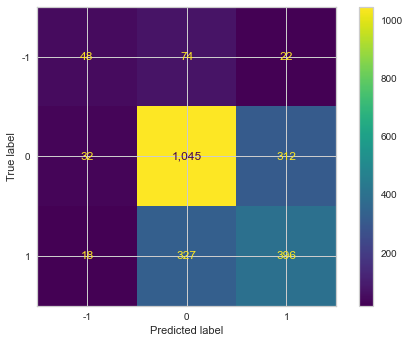

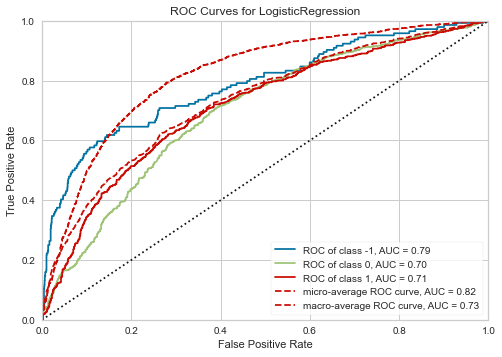

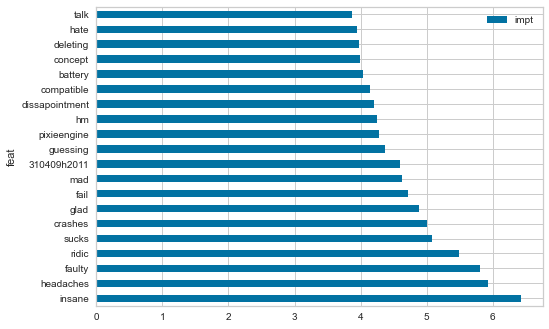

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=100, max_features='sqrt', min_samples_split=20,
                       random_state=42)
Train Scores
------------
Accuracy: 0.7307523097228332
F1 Score: 0.6976738690300528
ROC-AUC: 0.9200998061914957
Precision: 0.6642852013024063
-----------------------------------
Test Scores
-----------
Accuracy: 0.5708003518029904
F1 Score: 0.46514883752540803
ROC-AUC: 0.6448874221641216
Precision: 0.4588703559384188


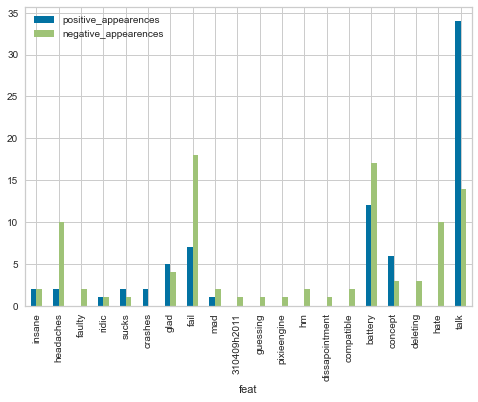

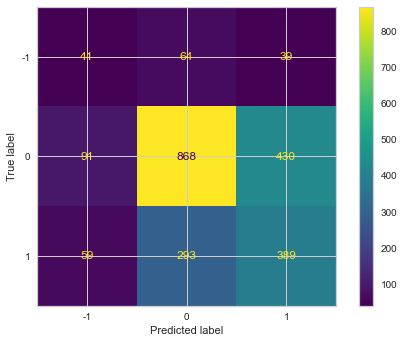

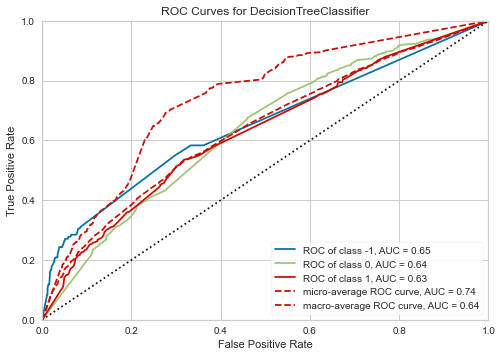

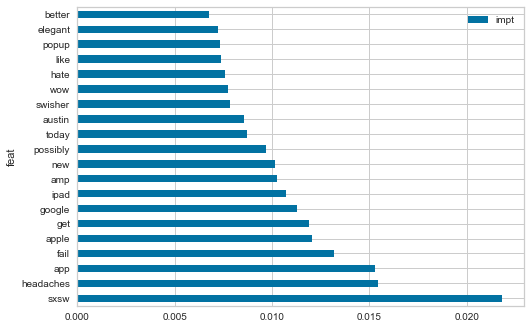

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=50, random_state=42)
Train Scores
------------
Accuracy: 0.9225692916849978
F1 Score: 0.9219661307900916
ROC-AUC: 0.9849006798586927
Precision: 0.9159439435386559
-----------------------------------
Test Scores
-----------
Accuracy: 0.6591908531222516
F1 Score: 0.5393002388574464
ROC-AUC: 0.7589793255136081
Precision: 0.6159883438562409


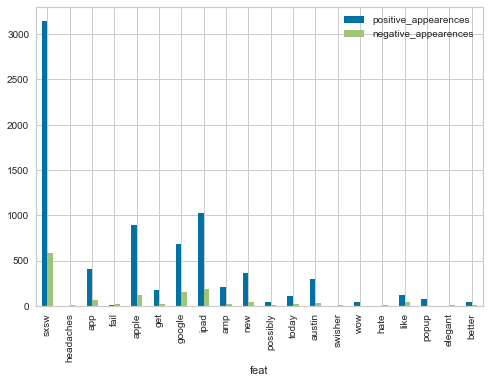

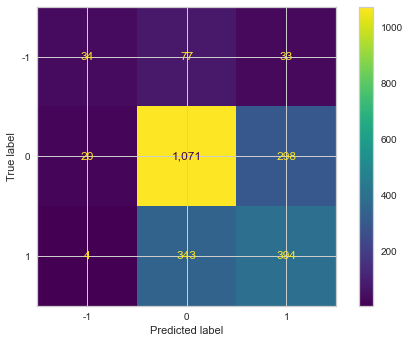

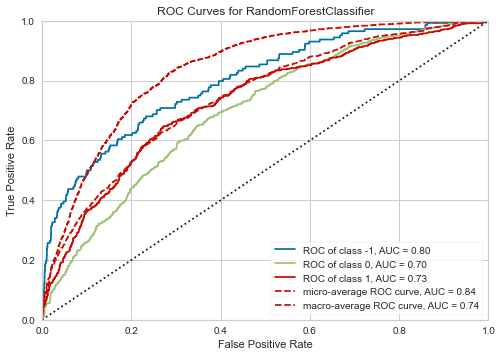

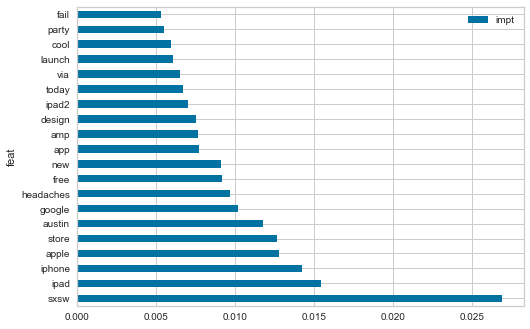

LogisticRegression(C=57.142857142857146, max_iter=5000, random_state=42,
                   solver='saga')
Train Scores
------------
Accuracy: 0.9546854377474703
F1 Score: 0.9513432574516213
ROC-AUC: 0.9976903271715755
Precision: 0.9586365043604067
-----------------------------------
Test Scores
-----------
Accuracy: 0.6429199648197009
F1 Score: 0.5390465920413221
ROC-AUC: 0.7193941252581034
Precision: 0.5633730510281557


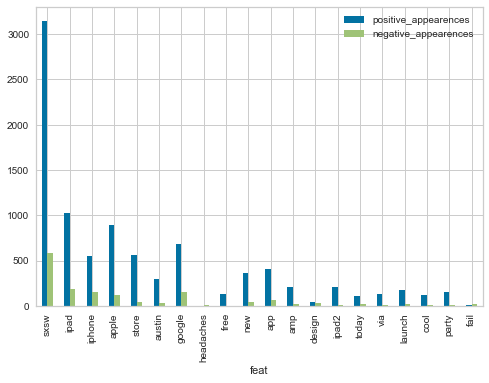

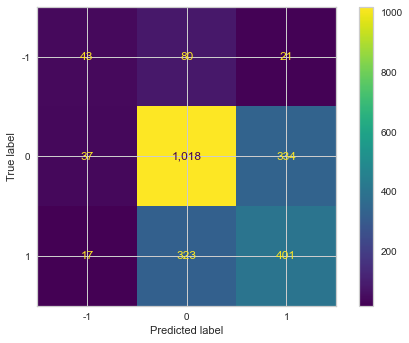

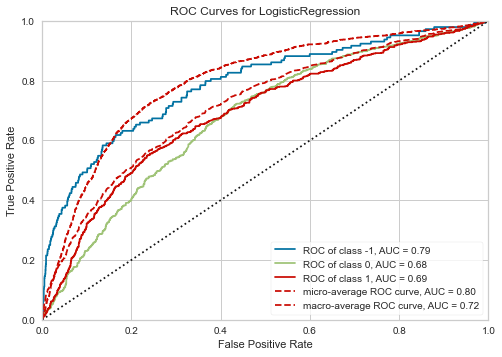

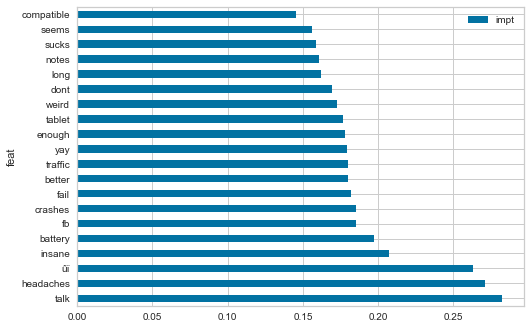

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=100, max_features='sqrt', min_samples_split=20,
                       random_state=42)
Train Scores
------------
Accuracy: 0.7307523097228332
F1 Score: 0.6976738690300528
ROC-AUC: 0.9200998061914957
Precision: 0.6642852013024063
-----------------------------------
Test Scores
-----------
Accuracy: 0.5708003518029904
F1 Score: 0.46514883752540803
ROC-AUC: 0.6448874221641216
Precision: 0.4588703559384188


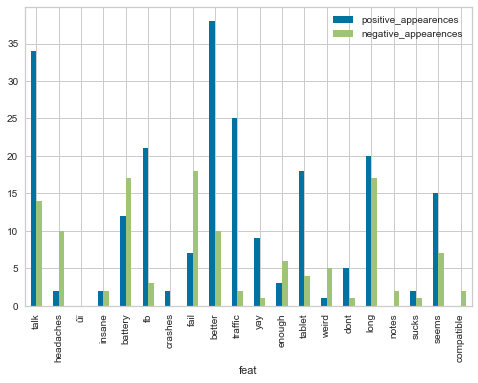

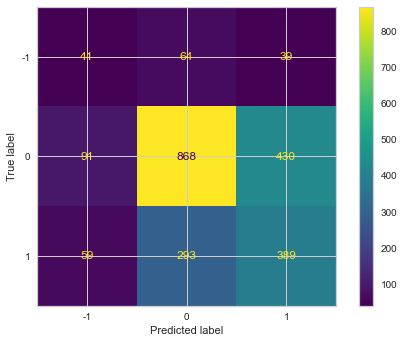

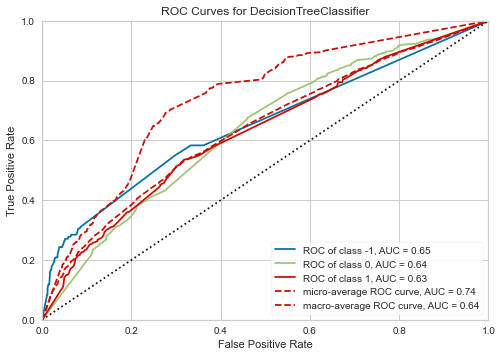

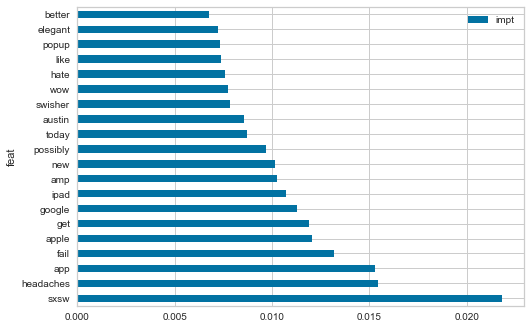

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=50, random_state=42)
Train Scores
------------
Accuracy: 0.9225692916849978
F1 Score: 0.9219661307900916
ROC-AUC: 0.9849006798586927
Precision: 0.9159439435386559
-----------------------------------
Test Scores
-----------
Accuracy: 0.6591908531222516
F1 Score: 0.5393002388574464
ROC-AUC: 0.7589793255136081
Precision: 0.6159883438562409


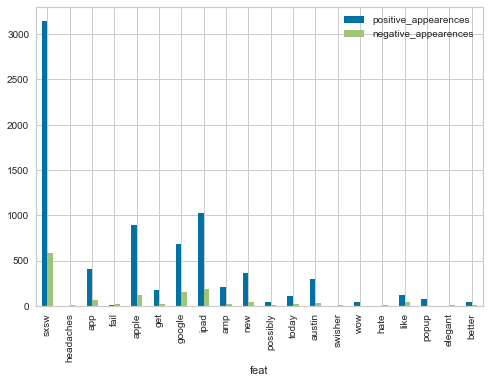

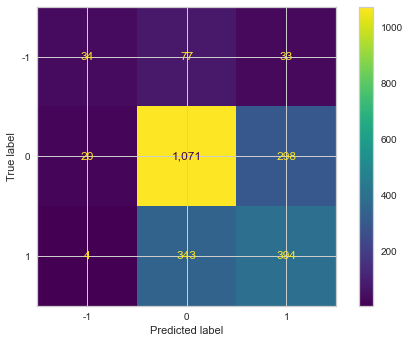

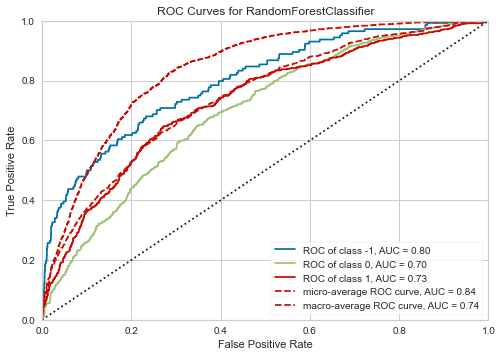

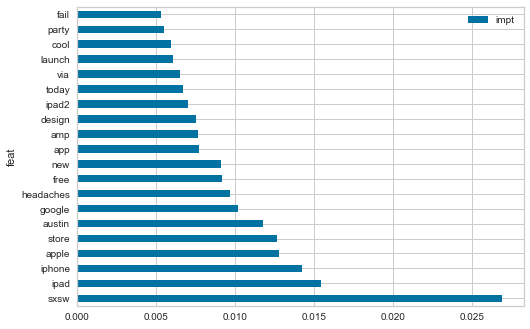

LogisticRegression(C=57.142857142857146, max_iter=5000, random_state=42,
                   solver='saga')
Train Scores
------------
Accuracy: 0.9472063352397713
F1 Score: 0.9434236654258306
ROC-AUC: 0.9956199452382052
Precision: 0.9560746892010812
-----------------------------------
Test Scores
-----------
Accuracy: 0.6732629727352683
F1 Score: 0.5755155004318416
ROC-AUC: 0.7528483719952876
Precision: 0.6151494182227409


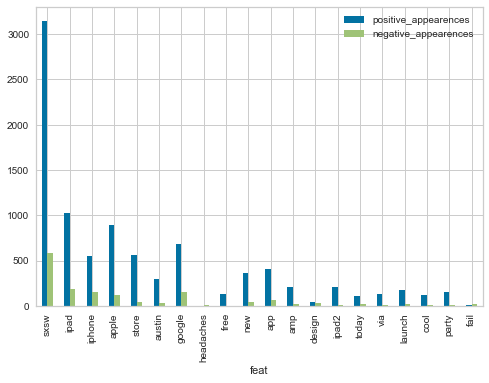

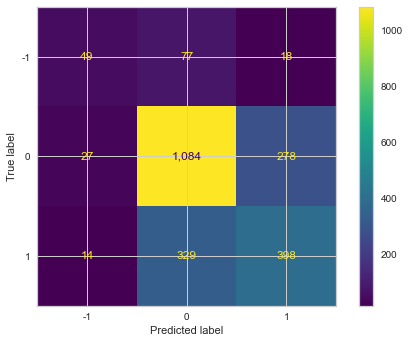

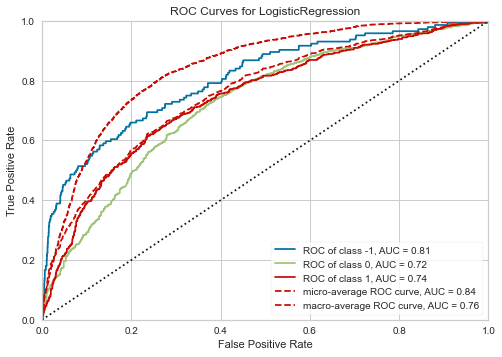

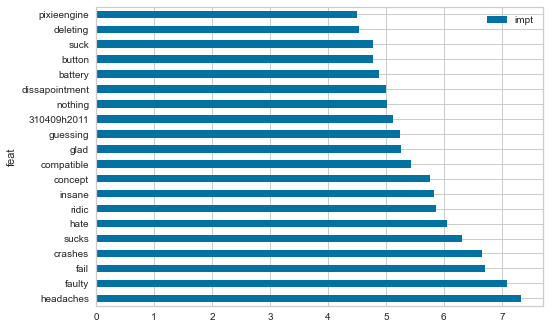

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=100, max_features='sqrt', min_samples_split=20,
                       random_state=42)
Train Scores
------------
Accuracy: 0.7307523097228332
F1 Score: 0.6976738690300528
ROC-AUC: 0.9200998061914957
Precision: 0.6642852013024063
-----------------------------------
Test Scores
-----------
Accuracy: 0.5708003518029904
F1 Score: 0.46514883752540803
ROC-AUC: 0.6448874221641216
Precision: 0.4588703559384188


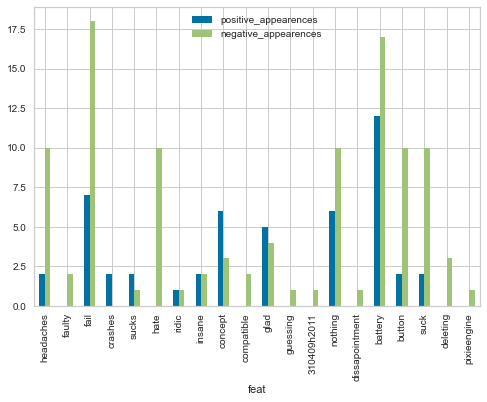

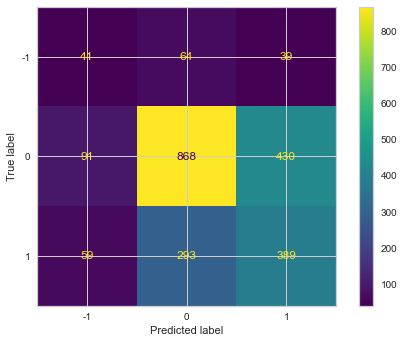

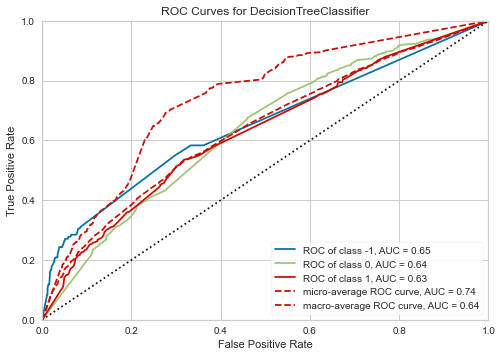

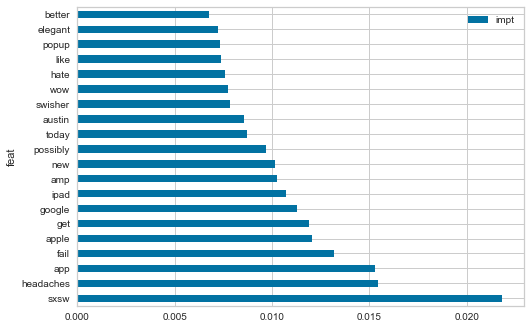

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=50, random_state=42)
Train Scores
------------
Accuracy: 0.9225692916849978
F1 Score: 0.9219661307900916
ROC-AUC: 0.9849006798586927
Precision: 0.9159439435386559
-----------------------------------
Test Scores
-----------
Accuracy: 0.6591908531222516
F1 Score: 0.5393002388574464
ROC-AUC: 0.7589793255136081
Precision: 0.6159883438562409


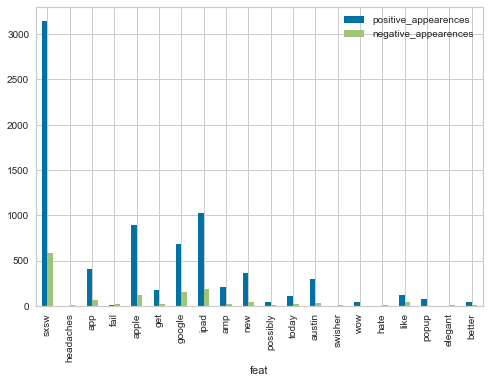

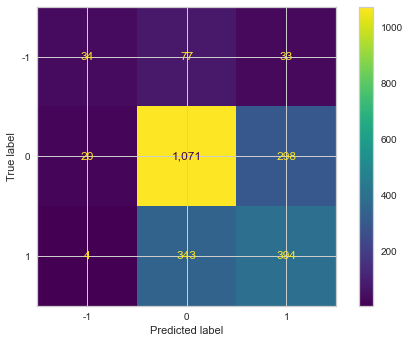

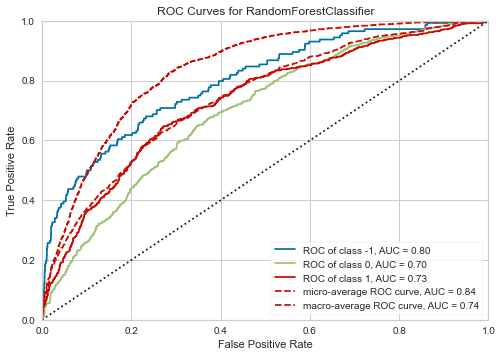

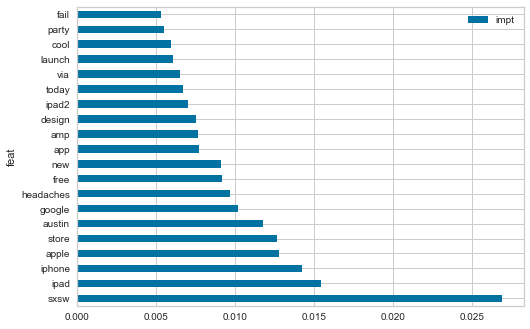

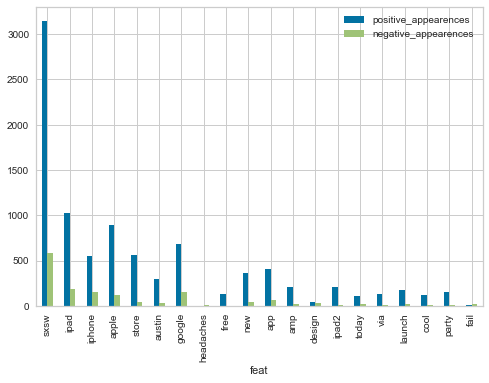

In [73]:
score = {}

for each in models:
    print(each[1]['classifier'])
    mr = ModelRunner(model = each, neutral = True, data = data, target = target)
    mr.run_model()
    for key, value in mr.score.items():
        score[key] = value

That's a lot of information! Let's take a quick and simple look at their scores.

In [74]:
x, y = [], []

for key, value in score.items():
    x.append(key)
    for k, v in value.items():
        if k == 'test':
            y.append(v)

In [75]:
score_df = pd.DataFrame(data=y, index=x).sort_values('ac', ascending=False)

score_df

,f1,roc-auc,ac,pr
"RobustScaler(with_centering=False) LogisticRegression(C=57.142857142857146, max_iter=5000, random_state=42,\n solver='saga')",0.575516,0.752848,0.673263,0.615149
"MaxAbsScaler() RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, random_state=42)",0.539300,0.758979,0.659191,0.615988
"StandardScaler(with_mean=False) RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, random_state=42)",0.539300,0.758979,0.659191,0.615988
"RobustScaler(with_centering=False) RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, random_state=42)",0.539300,0.758979,0.659191,0.615988
"MaxAbsScaler() LogisticRegression(C=71.42857142857143, random_state=42, solver='newton-cg')",0.557439,0.730435,0.654793,0.584982
"StandardScaler(with_mean=False) LogisticRegression(C=57.142857142857146, max_iter=5000, random_state=42,\n solver='saga')",0.539047,0.719394,0.642920,0.563373
"MaxAbsScaler() DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n max_depth=100, max_features='sqrt', min_samples_split=20,\n random_state=42)",0.465149,0.644887,0.570800,0.458870
"StandardScaler(with_mean=False) DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n max_depth=100, max_features='sqrt', min_samples_split=20,\n random_state=42)",0.465149,0.644887,0.570800,0.458870
"RobustScaler(with_centering=False) DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n max_depth=100, max_features='sqrt', min_samples_split=20,\n random_state=42)",0.465149,0.644887,0.570800,0.458870


Decision Trees are the worst here when looking at my two primary metrics, roc-auc and accuracy. I'll move forward with the top two - Logistic Regression with the Robust Scaler and Random Forest Classifier with the Max Abs Scaler. Due to the large gaps between the training scores and the test scores I'm going to try to adjust the hyperparameters in order to try to bring the two closer together, making the models more generalizable.

In [ ]:
param_range = [0.001,0.01,0.1,1,10,100,1000]

lr = LogisticRegression().set_params(**{'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'C': 57.142857142857146, 'random_state': 42})

train_scores, test_scores = validation_curve(estimator = lr,
                              X=RobustScaler(with_centering = False).fit_transform(TfidfVectorizer(stop_words=sw_list).fit_transform(data)),
                              y = target,
                              param_name='C',
                              param_range=param_range)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve")
# plt.xlabel(r"$\C$")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

C was clearly way too high. This suggests it should be around 1. Let's see what that does for overfitting

Train Scores
------------
Accuracy: 0.8162487168206481
F1 Score: 0.6350421064458632
ROC-AUC: 0.9369143042711259
Precision: 0.8706222763386533
-----------------------------------
Test Scores
-----------
Accuracy: 0.6895338610378188
F1 Score: 0.48401623854355563
ROC-AUC: 0.7631685888880577
Precision: 0.6798604250660828


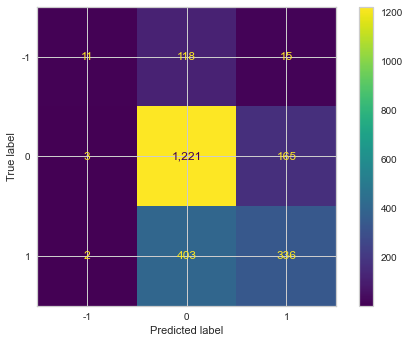

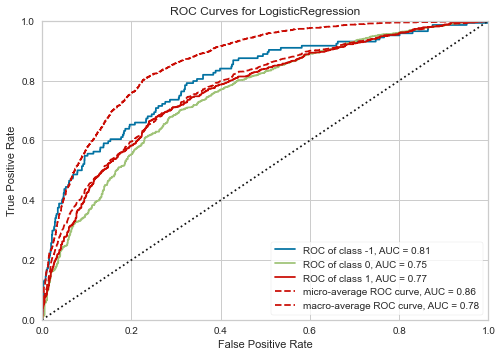

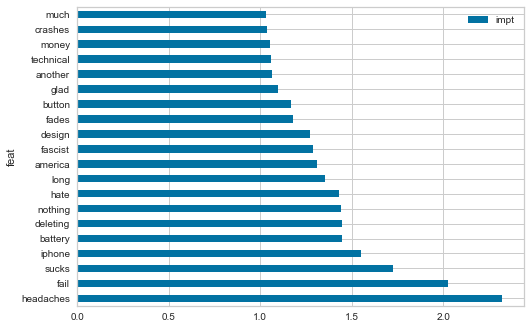

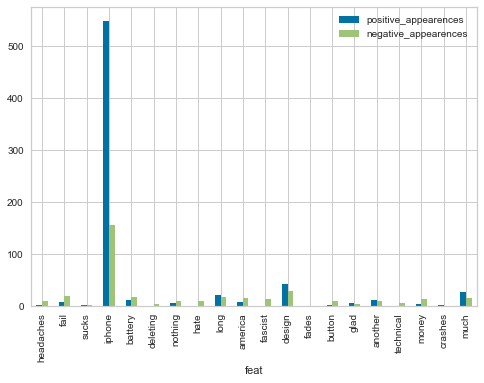

In [77]:
pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                       ('scaler', RobustScaler(with_centering=False)),
                        ('classifier', LogisticRegression(solver='saga', max_iter = 5000, C=1, random_state=42))])

models.append(({'classifier': pipe.steps[2][0], 'transformer': pipe.steps[0][0]}, pipe))
    
# for each in models[-1]:
mr = ModelRunner(model = models[-1], neutral = True, data = data, target = target)
mr.run_model()

In [90]:
s = {'ac' : 0.6895338610378188,
'f1' : 0.48401623854355563,
'roc-auc': 0.7631685888880577,
'pr': 0.6798604250660828
}
score_df = score_df.append(pd.DataFrame(data=s, index=["RobustScaler(with_centering=False) LogisticRegression(solver='saga', max_iter = 5000, C=1, random_state=42)"])).sort_values('ac', ascending=False)

We've increased both our roc-auc and accuracy to all-time highs. Let's see if max_iter can be adjusted to improve this even further.

In [ ]:
param_range = [-100,-10,1,10,100,1000,3000,5000,9000]

lr = LogisticRegression().set_params(**{'solver': 'saga', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': None, 'C': 1})

train_scores, test_scores = validation_curve(estimator = lr,
                              X=RobustScaler(with_centering=False).fit_transform(TfidfVectorizer(stop_words=sw_list).fit_transform(data)),
                              y = target,
                              param_name='max_iter',
                              param_range=param_range)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve")
# plt.xlabel(r"$\C$")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

The cross-validation score tops out at 100. Let's re-run the model with this hyperparameter

Train Scores
------------
Accuracy: 0.7971843378794544
F1 Score: 0.6036902255899407
ROC-AUC: 0.9167730165624316
Precision: 0.8538125272804624
-----------------------------------
Test Scores
-----------
Accuracy: 0.6873350923482849
F1 Score: 0.4689791137980441
ROC-AUC: 0.7574932534412092
Precision: 0.6726243761897411


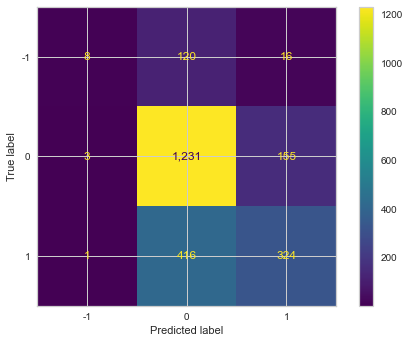

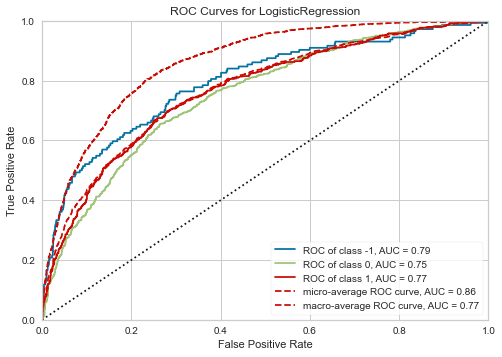

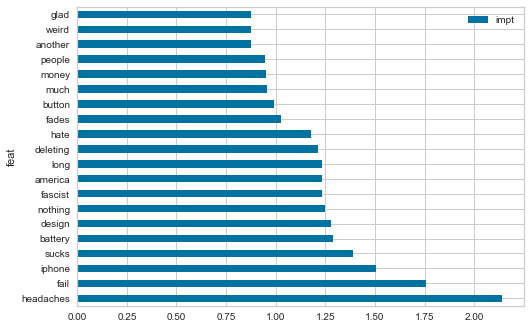

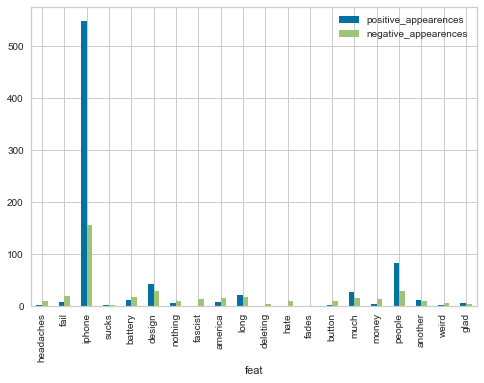

In [79]:
pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                       ('scaler', RobustScaler(with_centering=False)),
                        ('classifier', LogisticRegression(solver='saga', max_iter = 100, C=1, random_state=42))])

models.append(({'classifier': pipe.steps[2][0], 'transformer': pipe.steps[0][0]}, pipe))
    
# for each in models[-1]:
mr = ModelRunner(model = models[-1], neutral = True, data = data, target = target)
mr.run_model()

And let's add it to our model comparison table...

In [91]:
s = {'ac' : 0.6873350923482849,
'f1' : 0.4689791137980441,
'roc-auc': 0.7574932534412092,
'pr': 0.6726243761897411
}
score_df = score_df.append(pd.DataFrame(data=s, index=["RobustScaler(with_centering=False) LogisticRegression(solver='saga', max_iter = 100, C=1, random_state=42)"])).sort_values('ac', ascending=False)

score_df

,f1,roc-auc,ac,pr
"RobustScaler(with_centering=False) LogisticRegression(solver='saga', max_iter = 5000, C=1, random_state=42)",0.484016,0.763169,0.689534,0.679860
"RobustScaler(with_centering=False) LogisticRegression(solver='saga', max_iter = 100, C=1, random_state=42)",0.468979,0.757493,0.687335,0.672624
"RobustScaler(with_centering=False) LogisticRegression(C=57.142857142857146, max_iter=5000, random_state=42,\n solver='saga')",0.575516,0.752848,0.673263,0.615149
"MaxAbsScaler() RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, random_state=42)",0.539300,0.758979,0.659191,0.615988
"StandardScaler(with_mean=False) RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, random_state=42)",0.539300,0.758979,0.659191,0.615988
"RobustScaler(with_centering=False) RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, random_state=42)",0.539300,0.758979,0.659191,0.615988
"MaxAbsScaler() LogisticRegression(C=71.42857142857143, random_state=42, solver='newton-cg')",0.557439,0.730435,0.654793,0.584982
"StandardScaler(with_mean=False) LogisticRegression(C=57.142857142857146, max_iter=5000, random_state=42,\n solver='saga')",0.539047,0.719394,0.642920,0.563373
"MaxAbsScaler() DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n max_depth=100, max_features='sqrt', min_samples_split=20,\n random_state=42)",0.465149,0.644887,0.570800,0.458870
"StandardScaler(with_mean=False) DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n max_depth=100, max_features='sqrt', min_samples_split=20,\n random_state=42)",0.465149,0.644887,0.570800,0.458870


This is a bit hard to decypher. On the bright side, the train set scores went down, implying that the model is now more generalizable. On the other hand, so did the test set, meaning maybe the model is just overall worse. I think for a logistic regression the one with solver='saga', max_iter = 5000, C=1 is going to be my best. 

Now to run similar tests on my best performing Random Forest, MaxAbsScaler() RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, n_estimators=1000, random_state=42)	

In [ ]:
param_range = [1,10,100,1000,3000,5000,9000]

rf = RandomForestClassifier().set_params(**{'class_weight':'balanced', 'criterion':'entropy', 'max_depth':50, 'n_estimators':1000, 'random_state':42})

train_scores, test_scores = validation_curve(estimator = rf,
                              X=MaxAbsScaler().fit_transform(TfidfVectorizer(stop_words=sw_list).fit_transform(data)),
                              y = target,
                              param_name='max_depth',
                              param_range=param_range)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve")
plt.ylabel("Score")

lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

The cross-validation score plateaus at 100 so we'll run the model with that hyperparameter and see where it takes us.

In [ ]:
pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                       ('scaler', MaxAbsScaler()),
                        ('classifier', RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 100, n_estimators = 1000, random_state=42))])

models.append(({'classifier': pipe.steps[2][0], 'transformer': pipe.steps[0][0]}, pipe))
    
mr = ModelRunner(model = models[-1], neutral = True, data = data, target = target)
mr.run_model()

In [96]:
s = {'ac' : 0.6776605101143359,
'f1' : 0.5402746034453352,
'roc-auc': 0.7685362836290236,
'pr': 0.6383290125485327
}
score_df = score_df.append(pd.DataFrame(data=s, index=["RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 100, n_estimators = 1000, random_state=42)"])).sort_values('ac', ascending=False)

score_df

,f1,roc-auc,ac,pr
"RobustScaler(with_centering=False) LogisticRegression(C=57.142857142857146, max_iter=5000, random_state=42,\n solver='saga')",0.575516,0.752848,0.673263,0.615149
"MaxAbsScaler() RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, n_estimators=1000, random_state=42)",0.537782,0.761679,0.664028,0.624881
"StandardScaler(with_mean=False) RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, n_estimators=1000, random_state=42)",0.537782,0.761679,0.664028,0.624881
"RobustScaler(with_centering=False) RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=50, n_estimators=1000, random_state=42)",0.537091,0.761658,0.663149,0.624188
"MaxAbsScaler() LogisticRegression(C=71.42857142857143, random_state=42, solver='newton-cg')",0.557439,0.730435,0.654793,0.584982
"StandardScaler(with_mean=False) LogisticRegression(C=57.142857142857146, max_iter=5000, random_state=42,\n solver='saga')",0.539047,0.719394,0.642920,0.563373
"MaxAbsScaler() DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n max_depth=100, max_features='sqrt', min_samples_split=20,\n random_state=42)",0.465149,0.644887,0.570800,0.458870
"StandardScaler(with_mean=False) DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n max_depth=100, max_features='sqrt', min_samples_split=20,\n random_state=42)",0.465149,0.644887,0.570800,0.458870
"RobustScaler(with_centering=False) DecisionTreeClassifier(class_weight='balanced', criterion='entropy',\n max_depth=100, max_features='sqrt', min_samples_split=20,\n random_state=42)",0.465149,0.644887,0.570800,0.458870


These results show a slight increase in accuracy and roc-auc but not much change in the overfitting issue as the training scores are still very far from the testing scores. Let's try adjusting the n_estimators.

In [ ]:
param_range = [10, 100, 200, 500, 1000]

rf = RandomForestClassifier().set_params(**{'class_weight':'balanced', 'criterion':'entropy', 'max_depth':100, 'n_estimators':1000, 'random_state':42})

train_scores, test_scores = validation_curve(estimator = rf,
                              X=MaxAbsScaler().fit_transform(TfidfVectorizer(stop_words=sw_list).fit_transform(data)),
                              y = target,
                              param_name='n_estimators',
                              param_range=param_range)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve")
# plt.xlabel(r"$\C$")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Train Scores
------------
Accuracy: 0.9488194749963338
F1 Score: 0.9471296410521338
ROC-AUC: 0.9941878895441425
Precision: 0.9353793671311731
-----------------------------------
Test Scores
-----------
Accuracy: 0.6671064204045735
F1 Score: 0.5371445871815882
ROC-AUC: 0.758610269343095
Precision: 0.6259582738441822


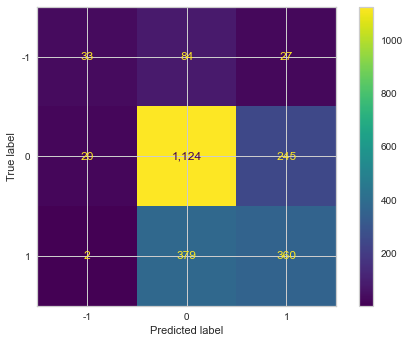

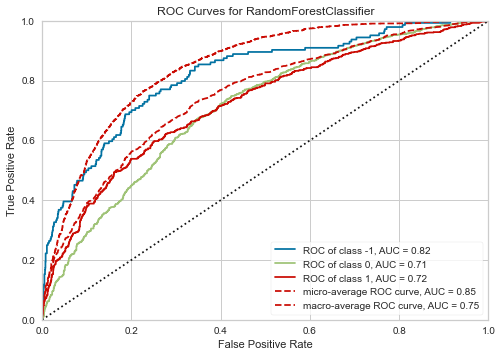

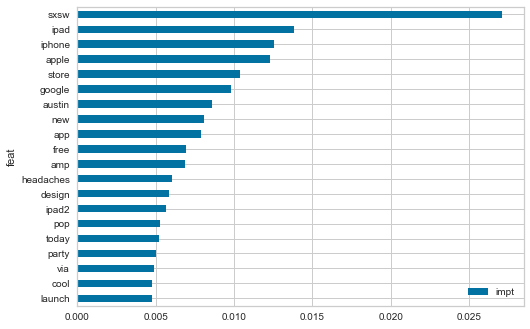

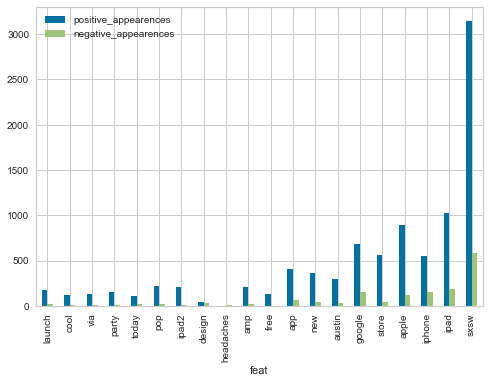

In [111]:
pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                       ('scaler', MaxAbsScaler()),
                        ('classifier', RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 100, n_estimators = 100, random_state=42))])

models.append(({'classifier': pipe.steps[2][0], 'transformer': pipe.steps[0][0]}, pipe))
    
# for each in models[-1]:
mr = ModelRunner(model = models[-1], neutral = True, data = data, target = target)
mr.run_model()

Here we've got a similar outcome to my last attempt at tuning my logarithmic model where both the training and test scores went down. On a suggestion from [stackexchange](https://stats.stackexchange.com/questions/111968/random-forest-how-to-handle-overfitting/112052) I've decided to check how random forest would perform with simply the default hyperparameters.

Train Scores
------------
Accuracy: 0.9623111893239478
F1 Score: 0.9574419084439939
ROC-AUC: 0.9979359562443418
Precision: 0.969160457520781
-----------------------------------
Test Scores
-----------
Accuracy: 0.6899736147757256
F1 Score: 0.5369539524733516
ROC-AUC: 0.7600861414892477
Precision: 0.6641373680163412


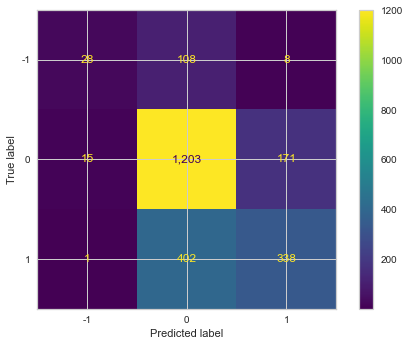

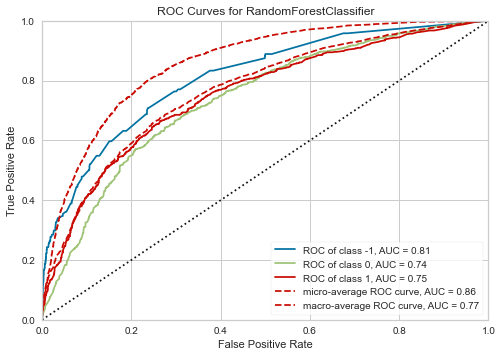

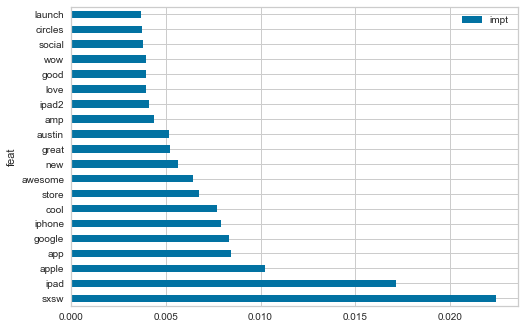

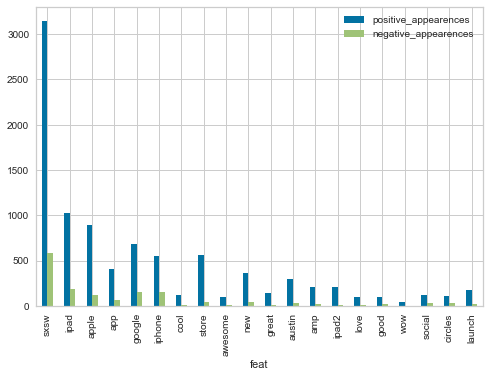

In [93]:
pipe = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                       ('scaler', MaxAbsScaler()),
                        ('classifier', RandomForestClassifier())])

models.append(({'classifier': pipe.steps[2][0], 'transformer': pipe.steps[0][0]}, pipe))
    
# for each in models[-1]:
mr = ModelRunner(model = models[-1], neutral = True, data = data, target = target)
mr.run_model()

It turns out all my tuning may have been for nothing as this produces the best test scores yet. My takeaway from this is that with the methods I've used in this notebook it's quite hard to model what seperates a tweet with a positive sentiment from one with a neutral or negative sentiment.



In [94]:
mr.impts.copy()['feat']

0             sxsw
1             ipad
2            apple
3              app
4           google
           ...    
8450    permission
8451    performers
8452    perception
8453    penetrates
8454          00pm
Name: feat, Length: 8455, dtype: object

In [ ]:
print('Apple Brands')
mr.impts[mr.impts['feat'].startswith(['apple', 'ipad', 'iphone', 'ipod'])]

In [100]:
print("Google Brands")
mr.impts[mr.impts['feat'].isin(['google', 'android', 'pixel', 'nexus'])]

Google Brands


,feat,impt,positive_appearences,negative_appearences
4,google,0.008321,680,148
32,android,0.002996,209,23
787,nexus,0.000251,3,3
4833,pixel,0.000018,3,0


In [103]:
print("Possible Google-associated Brands")
mr.impts[mr.impts['feat'].isin(['galaxy', 'samsung', 'droid'])]

Possible Google-associated Brands


,feat,impt,positive_appearences,negative_appearences
582,droid,0.000340,9,2
1023,samsung,0.000190,2,4
1782,galaxy,0.000105,2,1


# DONE???

Context, glove vectorization for semantic meaning

In [ ]:
models[]

In [257]:
pipe.steps[2][0]

'classifier'

In [ ]:
estimator = LogisticRegression().set_params(**grid.best_params_)

lr = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
               ('scaler', StandardScaler()),
                ('lr', estimator)])

tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                 ('scaler', StandardScaler()),
                ('Tree', DecisionTreeClassifier())])

rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
               ('scaler', StandardScaler()),               
                ('RandomForest', RandomForestClassifier())])

models = [({'classifier': 'lr', 'transformer': 'tfidfv'}, lr),
          ({'classifier': 'Tree', 'transformer': 'tfidfv'}, tree),
          ({'classifier': 'RandomForest', 'transformer': 'tfidfv'}, rf)
         ]

scores = [(name['classifier'], cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

scores

In [ ]:
for each in models:
    mr = ModelRunner(model = each, neutral = True, data = data, target = target)
    mr.run_model()

# re-do without no emotion, can't tell

In [ ]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

In [ ]:
filtered_df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

In [ ]:
filtered_df = filtered_df.reset_index()

In [ ]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
lemmatizer = WordNetLemmatizer()

r = []
data = []

for row in filtered_df['tweet_text']:
    for word in tokenizer.tokenize(row):
        r.append(lemmatizer.lemmatize(word))
    data.append(' '.join(r))
    r = []

data = pd.Series(data, name='tweet_text')
target = filtered_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)


# tfidf_data_train = tfidf.fit_transform(X_train)
# tfidf_data_test = tfidf.transform(X_test)

# tfidf_data_train

In [ ]:
lr = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
               ('scaler', MinMaxScaler()),
                ('lr', LogisticRegression())])

tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                 ('scaler', MinMaxScaler()),
                ('Tree', DecisionTreeClassifier())])

rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
               ('scaler', MinMaxScaler()),               
                ('RandomForest', RandomForestClassifier())])

models = [({'classifier': 'lr', 'transformer': 'tfidfv'}, lr),
          ({'classifier': 'Tree', 'transformer': 'tfidfv'}, tree),
          ({'classifier': 'RandomForest', 'transformer': 'tfidfv'}, rf)
         ]

scores = [(name['classifier'], cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

scores

In [ ]:
for each in models:
    mr = ModelRunner(model = each, neutral = False, data = data, target = target)
    mr.run_model()

In [ ]:
#TODO: logistic regression

# WORD VECTORIZATION

In [ ]:
word_list = []

for w in fdist.keys():
    if w not in sw_list:
        w = lemmatizer.lemmatize(w)
        word_list.append(w.lower())

In [ ]:
glove = {}
with open('glove.twitter.27B.25d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in word_list:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
glove

In [ ]:
len(glove)

In [ ]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        self.dimensions = 0 if len(w2v) == 0  else self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

lsvc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('LinearSVC', LinearSVC())])

tree = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Tree', DecisionTreeClassifier())])

In [ ]:
lr = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('lr', LogisticRegression())])

tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('Tree', DecisionTreeClassifier())])

rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('RandomForest', RandomForestClassifier())])

models = [('lr', lr),
          ('Tree', tree),
          ('RandomForest', rf)
         ]

scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

scores

In [ ]:
for name, model in models:
    run_model(name, model, X_train, X_test, y_train, y_test)

In [ ]:
#TODO: decision tree
#TODO: show metrics for why complex over simple model
#TODO: iterate models when justified